# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Image Caption Generator</b></div>

---

## **What is Image Captioning?**

- Image Captioning is the process of automatically generating a textual description for a given image.  
- It’s a fascinating blend of **Computer Vision** and **Natural Language Processing (NLP)** that enables machines to “see” and “talk” about what they observe.
- Most modern captioning systems use an **Encoder-Decoder architecture**, where an image is first encoded into a dense vector representation and then decoded into a sentence that describes the image content.

---

## **CNNs + RNNs (LSTMs)**

- To build an Image Caption Generator, we typically combine two deep learning architectures:
  
  🔹 **Convolutional Neural Networks (CNNs)**  
  are used to extract high-level features (embeddings) from the image. Pretrained CNNs like VGG, Xception, or ResNet are often used for this step.

  🔹 **Recurrent Neural Networks (LSTMs)**  
  handle the language modeling part. These networks receive the image features along with word embeddings to generate the next word in the caption sequence.

- This approach allows the model to learn the context of both **visual content** and **language structure**.
- For a visual representation of the model architecture, check the **Modeling** section below.

---


<img src="https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-3-031-58181-6_35/MediaObjects/546637_1_En_35_Fig3_HTML.png">

# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Project and Team</b></div>

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKzG04aVsH3CPLHLScCTg6RxTs4qeouSN52g&s" alt="Project Banner" style="width:100%; border-radius:10px; margin:20px 0"/>

This Image Caption Generator is a **Graduation Project** developed as part of the  
**Digital Egypt Pioneers Initiative – AI & Data Science Track (Microsoft Machine Learning Engineer)**.

> A fully-funded initiative provided by the **Ministry of Communications and Information Technology (MCIT)** for students and graduates from all universities and colleges across Egypt.

---

## 📘 Track Curriculum Overview

The track covers a wide variety of topics over 20 weeks:

- **Mathematics & Python**: Statistics, Linear Algebra, Data Structures, OOP  
- **Data Preprocessing & Visualization**: NumPy, Pandas, Seaborn, Real-world projects  
- **Machine Learning**: Regression, Classification, Model Evaluation, Ensemble Methods  
- **Deep Learning**: Neural Networks, TensorFlow, Regularization, Optimization  
- **Natural Language Processing**: RNNs, LSTMs, Transformers, Attention Mechanisms  
- **Computer Vision**: CNNs, Transfer Learning, Object Detection (YOLO, RCNN), GANs  
- **Azure AI Services**: Fundamentals of AI, Computer Vision, NLP on Azure  
- **MLOps**: Introduction to MLFlow and deployment tools

---

## 👥 Team Members

**Ahmed El-Hefnawy, Ahmed El-Tokhey, Samir Mohamed, Ahmed Adel, Amr Ghanem**


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Importing Libraries</b></div>

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, add, Concatenate, Reshape, concatenate

from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import os
import re

from tqdm import tqdm
import pickle

from PIL import Image
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download the necessary datasets
nltk.download('punkt')  # For word_tokenize
nltk.download('punkt_tab')  # For word_tokenize
nltk.download('stopwords')  # For stopwords
nltk.download('wordnet')

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ 

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!




<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Configure GPU Usage & Clear Memory Cache</b></div>

In [3]:
# Configure TensorFlow to use GPU by default
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.set_visible_devices(physical_devices[0], 'GPU')


In [4]:
import gc
def clear_cache():
    """
    Clears memory cache using garbage collector and TensorFlow backend clear session
    """
    # Clear TensorFlow session and free memory
    tf.keras.backend.clear_session()
    
    # Run garbage collector
    gc.collect()


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Loading Dataset</b></div>

In [5]:
BASE_DIR = "/kaggle/input/flickr-image-dataset/flickr30k_images"
WORK_DIR = "/kaggle/working"
images_path= os.path.join(BASE_DIR, 'flickr30k_images')

os.listdir(BASE_DIR)

['flickr30k_images', 'results.csv']

In [6]:
# Reading the results file.
captions = pd.read_csv(f"{BASE_DIR}/results.csv", sep='|', names=['image_name', 'comment_number', 'comment'])

In [7]:
captions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158916 entries, 0 to 158915
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   image_name      158916 non-null  object
 1   comment_number  158916 non-null  object
 2   comment         158915 non-null  object
dtypes: object(3)
memory usage: 3.6+ MB


In [8]:
captions.describe()

image_name comment_number                          comment
count          158916         158916                           158915
unique          31784              7                           158439
top     998845445.jpg              0   Two dogs playing in the snow .
freq                5          31783                                7

In [9]:
captions.isnull().sum()

image_name        0
comment_number    0
comment           1
dtype: int64

In [10]:
# Deleting null values
captions.dropna(inplace=True)

In [11]:
captions.isnull().sum()

image_name        0
comment_number    0
comment           0
dtype: int64

In [12]:
def print_samples(mapping: dict, samples = 5):
    for image, caption in list(mapping.items())[:samples]:
        print("Image:  ", image)
        print("Caption:", caption)
        print('-' * 50)
    



<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Preprocessing Texts (captions)</b></div>

In [13]:
# mapping the images with their captions.
mapping = captions.groupby('image_name')['comment'].apply(list).to_dict()

# Remove column name for keys
del mapping['image_name']

# Use only the first caption of each image
for image in mapping:
    mapping[image] = mapping[image][0]


print_samples(mapping)

Image:   1000092795.jpg
Caption:  Two young guys with shaggy hair look at their hands while hanging out in the yard .
--------------------------------------------------
Image:   10002456.jpg
Caption:  Several men in hard hats are operating a giant pulley system .
--------------------------------------------------
Image:   1000268201.jpg
Caption:  A child in a pink dress is climbing up a set of stairs in an entry way .
--------------------------------------------------
Image:   1000344755.jpg
Caption:  Someone in a blue shirt and hat is standing on stair and leaning against a window .
--------------------------------------------------
Image:   1000366164.jpg
Caption:  Two men , one in a gray shirt , one in a black shirt , standing near a stove .
--------------------------------------------------


In [14]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(txt):

    if not txt:
        return ""

    txt = txt.lower()
    
    text = re.sub(r'\s+', ' ', txt, flags=re.I) # Remove extra white space from text

    txt = re.sub(r'<.*?>', '', txt) # to remove html tags </>

    txt = re.sub(r'\W', ' ', str(txt)) # Remove all the special characters from text

    txt = re.sub(r'\s+[a-z]\s+', ' ', txt) # Remove all single characters from text

    txt = re.sub(r'[^a-z\s]', '', txt) # Remove any character that isn't alphabetical

    # # Removing Stop Words.
    # for word in STOPWORDS:
    #     token = ' ' + word + ' '
    #     txt = re.sub(token, ' ', txt)

    words = txt.split() # word_tokenize(txt)
    

    # words = [lemmatizer.lemmatize(word) for word in words]

    return words

In [15]:
for key in mapping:
    mapping[key] = ['<start>']+ preprocess_text(mapping[key]) + ['<end>']

print_samples(mapping)

Image:   1000092795.jpg
Caption: ['<start>', 'two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard', '<end>']
--------------------------------------------------
Image:   10002456.jpg
Caption: ['<start>', 'several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'giant', 'pulley', 'system', '<end>']
--------------------------------------------------
Image:   1000268201.jpg
Caption: ['<start>', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<end>']
--------------------------------------------------
Image:   1000344755.jpg
Caption: ['<start>', 'someone', 'in', 'blue', 'shirt', 'and', 'hat', 'is', 'standing', 'on', 'stair', 'and', 'leaning', 'against', 'window', '<end>']
--------------------------------------------------
Image:   1000366164.jpg
Caption: ['<start>', 'two', 'men', 'one', 'in', 'gray', 'shirt', 'one', 'in', 'black', 'shirt', 'standing', 'nea

In [16]:
x = [key for key, value in mapping.items()]
y = [value for key, value in mapping.items()]

print(len(x))
print(len(y))

31783
31783


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Spliting Captions</b></div>

In [17]:
# Split into train (60%), validation (20%), and test (20%) sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, train_size=0.6      , random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size=0.5, random_state=42)

In [18]:
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

19069 6357
19069 6357




<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Tokenization and Encoded Representation</b></div>

- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [19]:
# Make tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(y)

# Visualize word-index mapping
VOCAB_SIZE = len(tokenizer.word_index) + 1

print("Number of words: ", VOCAB_SIZE)
print("Word Indices:\n", list(tokenizer.word_index.items())[:5])
print("Index to Words:\n",list(tokenizer.index_word.items())[:5])


y_train_sequences = tokenizer.texts_to_sequences(y_train)
y_val_sequences = tokenizer.texts_to_sequences(y_val)
y_test_sequences = tokenizer.texts_to_sequences(y_test)

Number of words:  12168
Word Indices:
 [('<start>', 1), ('<end>', 2), ('in', 3), ('the', 4), ('and', 5)]
Index to Words:
 [(1, '<start>'), (2, '<end>'), (3, 'in'), (4, 'the'), (5, 'and')]


In [20]:
def decode(seq, tokenizer):
  return ' '.join([tokenizer.index_word[i] for i in seq if i != 0])

In [21]:
def idx_to_word(idx, tokenizer):
    """converts  idx to  word using tokenizer."""
    return tokenizer.index_word[idx]

In [22]:
for caption in mapping.values():
    print(caption)
    squence = tokenizer.texts_to_sequences([caption])
    print(squence[0])
    print(decode(squence[0], tokenizer))
    break

['<start>', 'two', 'young', 'guys', 'with', 'shaggy', 'hair', 'look', 'at', 'their', 'hands', 'while', 'hanging', 'out', 'in', 'the', 'yard', '<end>']
[1, 18, 26, 494, 6, 1917, 69, 160, 22, 61, 130, 19, 315, 88, 3, 4, 542, 2]
<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end>


## Padding

In [23]:
# Calculate the maximum sequence length
PADDING = len( max(y_train_sequences, key= len) )
print("Max Padding: ", PADDING)

Max Padding:  70


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Preprocessing Images</b></div>

In [24]:
# Creating images path
IMAGES_PATH = BASE_DIR + '/flickr30k_images'

len(os.listdir(IMAGES_PATH))

31785

In [25]:
# Showing first image.
first_image_path = IMAGES_PATH + '/' + os.listdir(IMAGES_PATH)[0]

image = Image.open(first_image_path)

print("Raw Image Dims:".ljust(25), image.size)

# Increasing the dimensions of the images.f
image = np.array(image)
image = np.expand_dims(image, axis=0)

# Getting the shape of the image (1, width, height, channels)
print("Pre-Processed Image Dims:", image.shape)

Raw Image Dims:           (500, 333)
Pre-Processed Image Dims: (1, 333, 500, 3)


In [26]:
# Unify Image Dimensions
UNISHAPE = (299, 299)
def preprocess_image(image_path, dims= UNISHAPE):
    # Stretch the image
    image = load_img(image_path, target_size=UNISHAPE)
    image = img_to_array(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)

    return image

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Displaying Image Samples</b></div>

In [27]:
def read_image(path, img_size=UNISHAPE):
    img = load_img(path, color_mode='rgb', target_size= img_size)
    img = img_to_array(img)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

In [28]:
def plot_image(image):    
    plt.imshow(image)
    plt.axis(False)
    plt.grid(False)
    plt.show()

In [29]:
def show_data_sample(data, images_folder_path, sample_size = 3):
    i = 0
    samples = random.sample(list(data.items()), sample_size)
    for image_name, caption in samples:
        image_path = os.path.join(images_folder_path, image_name)
        image_array = read_image(image_path)
        
        plot_image(image_array)
        
        print(caption)
        print('\n')
    

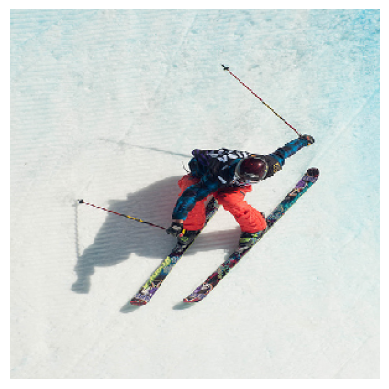

['<start>', 'person', 'in', 'orange', 'pant', 'skiing', 'in', 'an', 'event', 'sponsored', 'by', 'visa', '<end>']




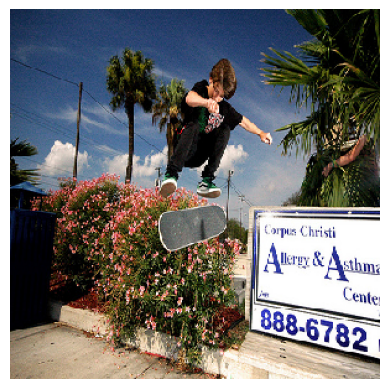

['<start>', 'the', 'boy', 'in', 'black', 'is', 'skateboarding', 'in', 'the', 'air', 'in', 'front', 'of', 'the', 'flowers', 'and', 'white', 'and', 'blue', 'sign', '<end>']




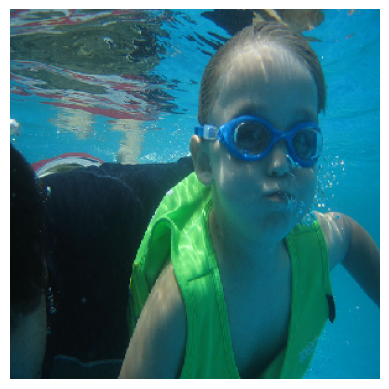

['<start>', 'blond', 'child', 'is', 'wearing', 'blue', 'goggles', 'and', 'green', 'speedo', 'tank', 'top', 'while', 'swimming', 'underwater', '<end>']




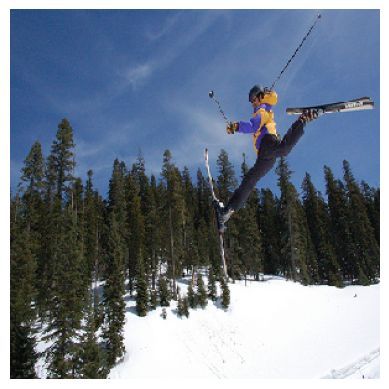

['<start>', 'skier', 'splits', 'his', 'or', 'her', 'legs', 'while', 'flying', 'throught', 'the', 'air', 'over', 'ski', 'hill', '<end>']




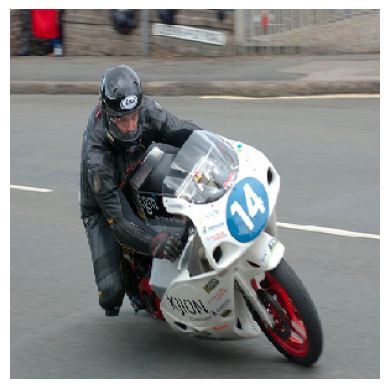

['<start>', 'man', 'dressed', 'in', 'black', 'dramatically', 'rides', 'racing', 'motorcycle', 'along', 'stretch', 'of', 'street', 'pavement', '<end>']




In [30]:
random.seed(432543)
show_data_sample(mapping, IMAGES_PATH, 5)

# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Image Feature Extraction using Xception</b></div>

In this project, we use the **Xception** model for extracting image features. Xception is a powerful convolutional neural network architecture pre-trained on the ImageNet dataset.

- We remove the top layers of the model (used for classification) and retain the core convolutional base.
- Instead of flattening the final feature maps, we apply a **Global Average Pooling** layer to obtain a fixed-size vector representation for each image.
- As a result, each image is converted into a **2048-dimensional embedding vector**, capturing the essential visual features of the image.

These embeddings are later fed into the text generation part of our model to help generate relevant captions.

---

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/0*Td_tuccmD6fleWNk.gif" alt="Xception Model" width="90%">
</p>


In [31]:
features_path = "/kaggle/input/xception-flickr30k-images-features/features.pkl"

base_model = Xception(include_top=False, pooling='avg')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
def save_pkl(features, features_path):
        # Save features using pickle
        print("Saving features to:", features_path)
        with open(features_path, 'wb') as f:
            pickle.dump(features, f)
        print(f"Saved {len(features)} features successfully!")

def extract_features(model, image_data, preprocessor, images_path=images_path, features_path= features_path, img_size= UNISHAPE):
    if os.path.exists(features_path):
        print("Loading existing features from:", features_path)
        with open(features_path, 'rb') as f:
            features = pickle.load(f)
        print(f"Loaded {len(features)} features successfully!")
    else:
        print("No saved features found. Starting feature extraction...")


        model.trainable = False
        fe = Model(inputs=model.input, outputs=model.layers[-1].output)

        features = {}

        for image in tqdm(image_data):
            img = preprocess_image(os.path.join(images_path, image))
            feature = fe.predict(img, verbose=0)
            features[image] = feature

        save_pkl(features, WORK_DIR)
    return features

In [33]:
print(f"Extracting features to path {features_path}")
features = extract_features(base_model, x, preprocess_input)

Extracting features to path /kaggle/input/xception-flickr30k-images-features/features.pkl
Loading existing features from: /kaggle/input/xception-flickr30k-images-features/features.pkl
Loaded 31783 features successfully!


<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Buliding The Model</b></div>

- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end
<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [34]:
def build_model(padding, num_words, lstm_units=256, dense_units=128, dropout_rate=0.5):
    input_feature = Input(shape=(2048,))
    
    # Project image features to lstm_units to match shape
    img_features = Dense(lstm_units, activation="relu")(input_feature)
    img_features_reshaped = Reshape((1, lstm_units))(img_features)
    
    input_caption = Input(shape=(padding,))
    sentence_features = Embedding(num_words, lstm_units, mask_zero=False)(input_caption)

    merged = concatenate([img_features_reshaped, sentence_features], axis=1)
    sentence_features = LSTM(lstm_units)(merged)

    x = Dropout(dropout_rate)(sentence_features)
    x = add([x, img_features])  # Now shapes match (both lstm_units)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_words, activation='softmax')(x)

    caption_model = Model(inputs=[input_feature, input_caption], outputs=output)
    caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return caption_model

# def build_model(padding, num_words, lstm_units=256, dense_units=128, dropout_rate=0.5):
#     """
#     Builds a captioning model with customizable architecture.

#     Parameters:
#     - padding: Length of the input sequence for captions (padded).
#     - num_words: Size of the vocabulary.
#     - lstm_units: Number of units in the LSTM layer (default: 256).
#     - dense_units: Number of units in the Dense layer (default: 128).
#     - dropout_rate: Dropout rate to prevent overfitting (default: 0.5).

    # Returns:
    # - caption_model: The compiled model.
    # """
    
    # # Image Feature path 
    # input_feature = Input(shape=(2048,))
    # try:
    #     img_features = Dense(256, activation="relu")(input_feature)
    # except:
    #     img_features = Dense(128, activation="relu")(input_feature)
    # img_features_reshaped = Reshape((1, 256))(img_features)
    
    # # Caption Sequence Path
    # input_caption = Input(shape=(padding,))
    # sentence_features = Embedding(num_words, 256, mask_zero=False)(input_caption)

    # # Merge and LSTM 
    # merged = concatenate([img_features_reshaped, sentence_features], axis=1)
    # sentence_features = LSTM(lstm_units)(merged)

    # # Combined Output
    # x = Dropout(dropout_rate)(sentence_features)
    # x = add([x, img_features])
    # x = Dense(dense_units, activation='relu')(x)
    # x = Dropout(dropout_rate)(x)
    # output = Dense(num_words, activation='softmax')(x)

    # # Model Definition
    # caption_model = Model(inputs=[input_feature, input_caption], outputs=output)
    # caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # return caption_model

# def build_model(padding, num_words):
#     # Image Feature path 
#     input_feature=Input(shape=(2048,))
#     img_features=Dense(256,activation="relu")(input_feature)
#     img_features_reshaped=Reshape((1, 256))(img_features)
    
#     # Caption Sequence Path
#     input_caption= Input(shape=(padding,))
#     sentence_features= Embedding(num_words, 256, mask_zero=False)(input_caption)

#     # Merge and LSTM 
#     merged= concatenate([img_features_reshaped, sentence_features],axis=1)
#     sentence_features= LSTM(256)(merged)

#     #  Combined Output 
#     x=Dropout(0.5)(sentence_features)
#     x=add([x, img_features])
#     x=Dense(128,activation='relu')(x)
#     x=Dropout(0.5)(x)
#     output=Dense(num_words, activation='softmax')(x)

#     #  Model Definition 
#     caption_model=Model(inputs=[input_feature, input_caption], outputs=output)
#     caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     return caption_model

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Model Shape</b></div>

In [35]:
model = build_model(PADDING, VOCAB_SIZE)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 70)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 70, 256)        │      3,115,008 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 71, 256)        │              0 │ reshape[0][0],         │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 256)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ add_12[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 12168)          │      1,569,672 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,767,432 (22.00 MB)

 Trainable params: 5,767,432 (22.00 MB)

 Non-trainable params: 0 (0.00 B)

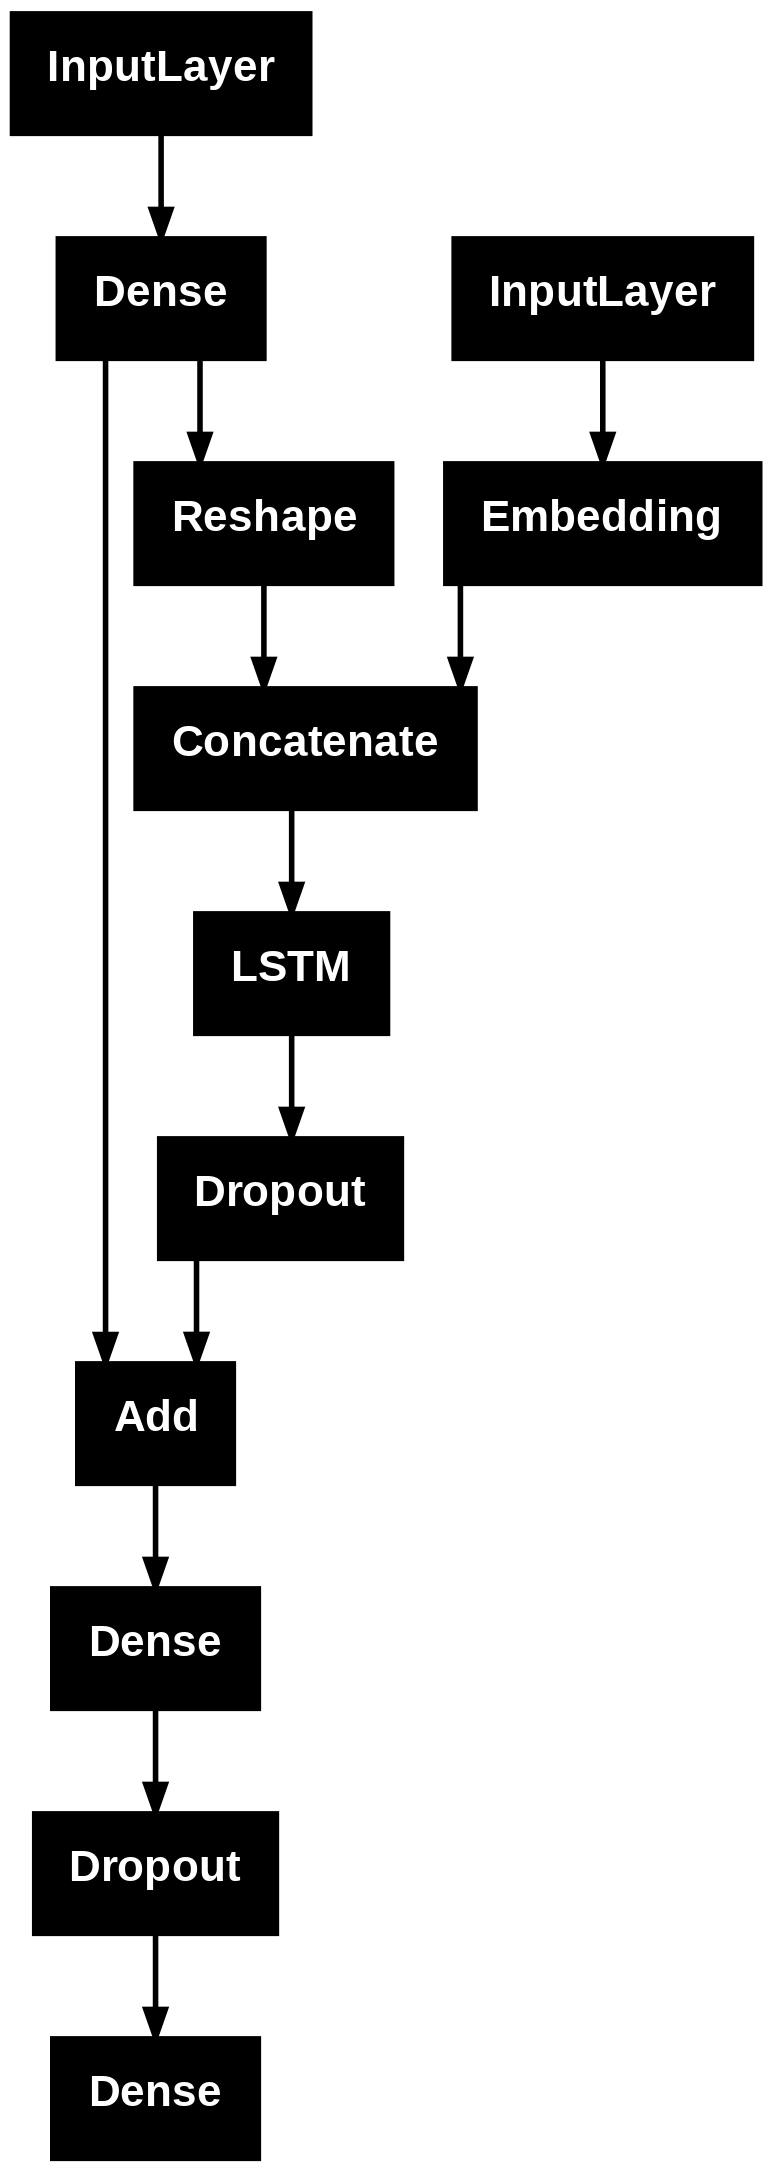

In [36]:
plot_model(model)

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Data Generator</b></div>

To visualize some examples from our dataset, we created a **custom data generator** that helps load and preprocess image-caption pairs efficiently. This is especially useful when working with large datasets, as it allows us to load data in batches without overwhelming memory.


- **Purpose**: Dynamically loads images and their corresponding preprocessed captions.
- **Image Processing**: Images are resized and normalized to match the input requirements of the Xception model.
- **Caption Processing**: Captions are tokenized, padded, and prepared for sequence modeling.

This generator is also later used during training to feed batches of `(image_features, input_sequence)` as input and `next_word` as the target output for the model.

---

✅ Below are a few randomly selected image samples from the dataset, along with their corresponding captions, to get an idea of what our model will learn to generate.


In [37]:
def generate_caption(model, image, tokenizer, max_length=40):
    """
    Generate a caption for an image using the trained model.
    
    Parameters:
    - model: Trained captioning model
    - image: Preprocessed image input (shape must match model input)
    - tokenizer: Tokenizer to convert words to indexes and vice versa
    - max_length: Maximum caption length

    Returns:
    - Generated caption as a list of words
    """
    # Start with the <start> token
    caption = ["<start>"]

    for _ in range(max_length):
        # Convert words to token IDs
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Predict next word (model expects [image, sequence])
        y_pred = model.predict([image, sequence], verbose=0)
        
        # Get the word index with the highest probability
        next_word_id = np.argmax(y_pred)

        # Convert index to word
        next_word = tokenizer.index_word.get(next_word_id, "<unk>")

        # Stop if end token is generated
        if next_word == "<end>":
            break
        
        caption.append(next_word)

    return caption[1:]  # Remove <start> token

In [38]:
class CustomDataGenerator(Sequence):
    def __init__(self,df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle=True, **kwargs):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.directory = directory
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
       if self.shuffle:
           self.df = self.df.sample(frac= 1).reset_index(drop= True)

    def __len__(self):
       return self.n // self.batch_size

    def __getitem__(self, index):
       batch = self.df.iloc[index *self.batch_size: (index+1) * self.batch_size, :]
       X1, X2, y = self.__get_data(batch)
       return (X1, X2), y
    
    def __get_data(self, batch):
       X1, X2, y = [], [], []
       images = batch[self.X_col].tolist()

       for image in images :
           feature = self.features[image][0]
           captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()

           for caption in captions:
               seq= self.tokenizer.texts_to_sequences([caption])[0]
               for i in range(len(seq)):
                   in_seq, out_seq = seq[:i], seq[i]
                   in_seq = pad_sequences([in_seq], maxlen= self.max_length)[0]

                   out_seq = to_categorical([out_seq], num_classes= self.vocab_size)[0]
                   X1.append(feature)
                   X2.append(in_seq)
                   y.append(out_seq)

       X1, X2, y = np.array(X1), np.array(X2), np.array(y)
       return X1,X2,y

In [39]:
train_df = pd.DataFrame({'image': x_train, 'caption': y_train})
val_df = pd.DataFrame({'image': x_val, 'caption': y_val})
test_df = pd.DataFrame({'image': x_test, 'caption': y_test})

train_generator = CustomDataGenerator(df= train_df, X_col= 'image',y_col= 'caption',batch_size= 64, directory= images_path,
                                   tokenizer= tokenizer,vocab_size= VOCAB_SIZE, max_length=  PADDING,features= features)

validation_generator = CustomDataGenerator(df= val_df, X_col= 'image',y_col= 'caption',batch_size= 64, directory= images_path,
                                   tokenizer= tokenizer,vocab_size= VOCAB_SIZE, max_length=  PADDING,features= features)

test_generator = CustomDataGenerator(df= test_df, X_col= 'image',y_col= 'caption',batch_size= 64, directory= images_path,
                                   tokenizer= tokenizer,vocab_size= VOCAB_SIZE, max_length=  PADDING,features= features)

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Model Training Callbacks</b></div>

In [40]:
model_name='caption_model.keras'

checkpoint=ModelCheckpoint(model_name,
                           monitor='val_loss',
                           mode='min',
                           save_best_only=True,
                           verbose=1)

earlystopping=EarlyStopping(monitor='val_loss',
                             min_delta=0,
                             patience=5,
                             verbose=1,
                             restore_best_weights=True)

learinig_rate_reduction=ReduceLROnPlateau(monitor='val_loss',
                                          patience=3,
                                          verbose=1,
                                          factor=0.2,
                                          min_lr=0.00000001)

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Let's train the Model</b></div>

<img src="https://media.giphy.com/media/pw2fLKLW3mgw/giphy.gif" style="width:100%; height:auto;">


In [41]:
history = model.fit(
            train_generator,
            epochs=50,
            validation_data=validation_generator,
            callbacks=[checkpoint, earlystopping, learinig_rate_reduction]
        )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.1019 - loss: 6.2937
Epoch 1: val_loss improved from inf to 4.95033, saving model to caption_model.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 101s 320ms/step - accuracy: 0.1021 - loss: 6.2916 - val_accuracy: 0.2122 - val_loss: 4.9503 - learning_rate: 0.0010
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.2080 - loss: 4.9528
Epoch 2: val_loss improved from 4.95033 to 4.58570, saving model to caption_model.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 95s 313ms/step - accuracy: 0.2080 - loss: 4.9525 - val_accuracy: 0.2414 - val_loss: 4.5857 - learning_rate: 0.0010
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.2357 - loss: 4.6163
Epoch 3: val_loss improved from 4.58570 to 4.40376, saving model to caption_model.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 95s 313ms/step - accuracy: 0.2357 - loss: 4.6162 - val_accuracy: 0.2574 - val_loss: 4.4038 - learning_rate: 0.0010
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step 

<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Acuuracy & Loss Plots</b></div>

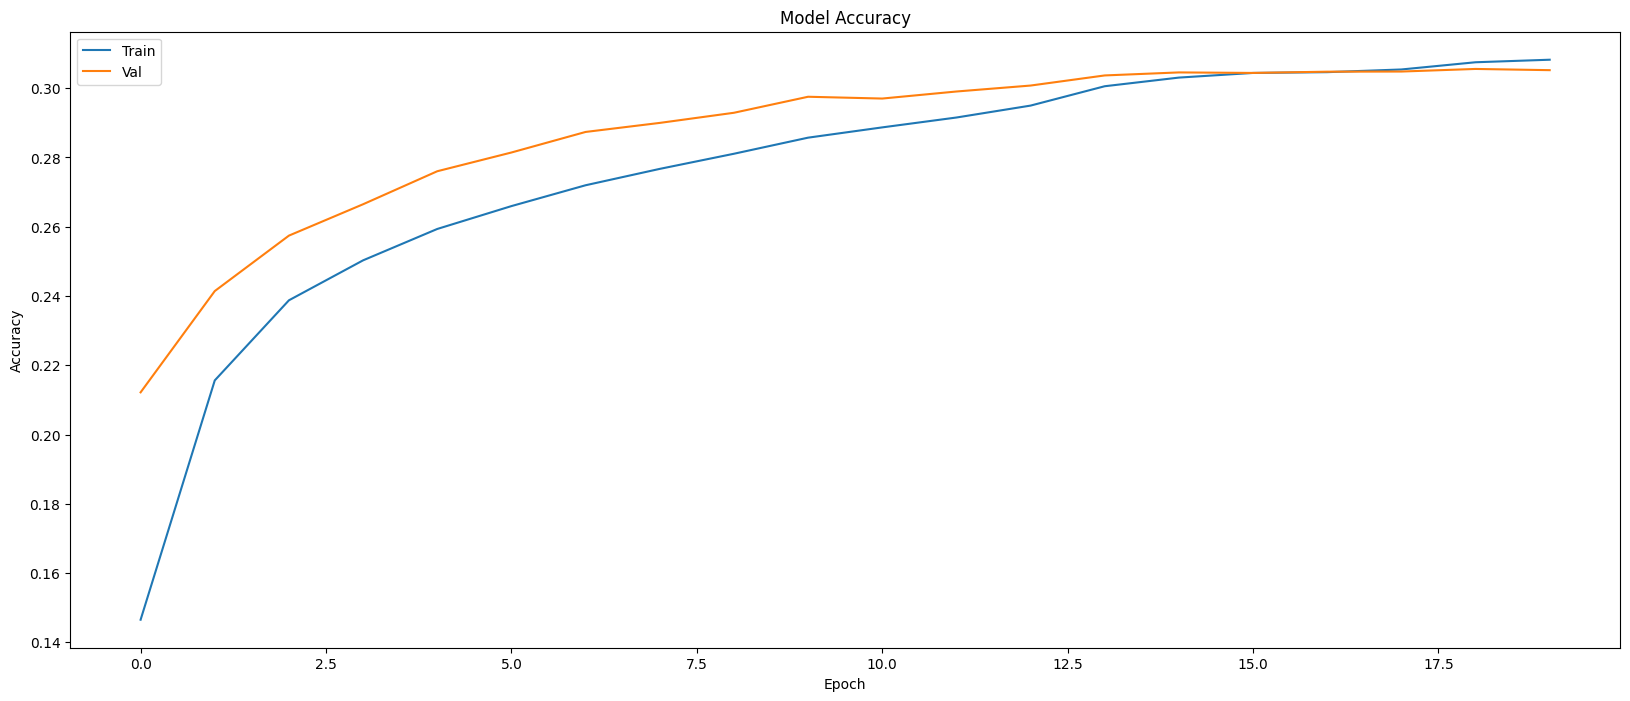

In [42]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

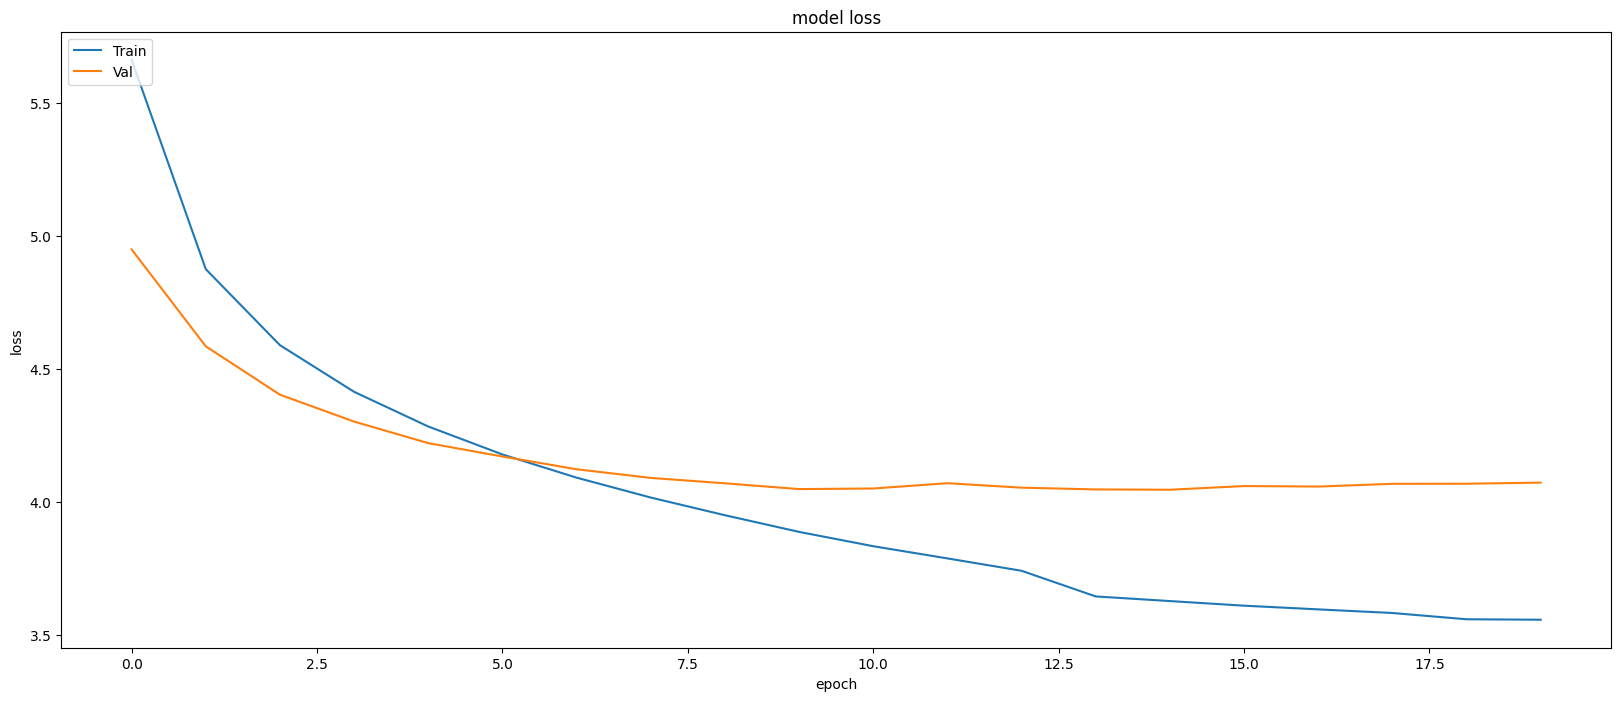

In [43]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [44]:
model.evaluate(test_generator)

99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.3032 - loss: 4.0426


[4.046581268310547, 0.3038800060749054]



<a id="2"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b>Why Beam Search in Caption Prediction?</b></div>

- **Greedy Search** chooses the most probable word at each step, but it may lead to repetitive or incomplete captions.
- **Beam Search** explores multiple sequences at each step, keeping track of the top-k most likely sequences, ensuring better captions.

<img src="https://ericwiener.github.io/ai-notes/AI-Notes/Definitions/beam-search-srcs/beam-search-20220302094517245.png">

In [45]:
def predict_caption_with_beam_search(model, image, tokenizer, max_length, features, beam_size=3):
    """
    Generate image captions using beam search instead of greedy search.

    Args:
        model: Your trained caption generation model
        image: Image filename
        tokenizer: The tokenizer used during training
        max_length: Maximum caption length
        features: Dictionary of pre-extracted image features
        beam_size: Number of beams to use (default: 3)

    Returns:
        The best caption based on overall sequence probability
    """
    # Get image features
    feature = features[image]

    # Initialize with start token
    start = tokenizer.texts_to_sequences(['<start>'])[0]

    # Initialize beam
    # Each beam contains (sequence, sequence_score, completed_flag)
    beams = [(start, 0.0, False)]

    # Generate until max length or all beams complete
    for _ in range(max_length):
        all_candidates = []

        # Check if all sequences are complete
        if all(completed for _, _, completed in beams):
            break

        # Expand each beam
        for seq, score, completed in beams:
            # Skip if this sequence is already completed
            if completed:
                all_candidates.append((seq, score, completed))
                continue

            # Prepare sequence for prediction
            padded_seq = pad_sequences([seq], maxlen=max_length)[0]
            padded_seq = np.reshape(padded_seq, (1, max_length))

            # Predict next word probabilities
            y_pred = model.predict([feature, padded_seq], verbose=0)

            # Get top-k predictions
            top_indices = np.argsort(y_pred[0])[-beam_size:]
            top_probs = y_pred[0][top_indices]

            # Create new candidates
            for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
                word = idx_to_word(idx, tokenizer)

                # Skip if word is None
                if word is None:
                    continue

                # Create new sequence
                new_seq = seq.copy()
                new_seq.append(idx)

                # Calculate new score (log probability)
                # Using log probabilities helps prevent underflow with long sequences
                new_score = score + np.log(prob)

                # Check if sequence is complete
                is_complete = (word == '<end>')

                all_candidates.append((new_seq, new_score, is_complete))

        # Sort candidates by score and select top beam_size
        all_candidates.sort(key=lambda x: x[1], reverse=True)
        beams = all_candidates[:beam_size]

    # Find the best completed sequence
    completed_beams = [b for b in beams if b[2]]

    # If none completed, take the best incomplete sequence
    if not completed_beams:
        completed_beams = beams

    # Get words from the best sequence
    best_seq = completed_beams[0][0]
    caption_indices = best_seq[1:]  # Remove start token

    # Convert indices to words
    caption_words = []
    for idx in caption_indices:
        word = idx_to_word(idx, tokenizer)
        if word == '<end>' or word is None:
            break
        caption_words.append(word)

    return ' '.join(caption_words)

In [46]:
def predict_caption(model, image, tokenizer, max_length, features):
    # Get image features
    feature = features[image]

    # Initialize with start token
    

    output_seq = '<start>'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([output_seq])[0]
        
        # Prepare sequence for prediction
        padded_seq = pad_sequences([seq], maxlen=max_length)
        
        # Predict next word probabilities
        y_pred = model.predict([feature, padded_seq], verbose=0)
    
        idx = np.argmax(y_pred)
    
        # Convert indices to words
        word = idx_to_word(idx, tokenizer)
        if word == '<end>' or word is None:
            break
        output_seq += ' ' + word

    return output_seq[8:]

In [47]:
samples= train_df.sample(15).copy()
samples.reset_index(drop=True,inplace=True)



<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Predicting Random Sample of Train Images </b></div>

Beam: man in white shirt and black pants is standing in front of the ocean
Greedy: young girl in black shirt and black pants is standing in front of the water


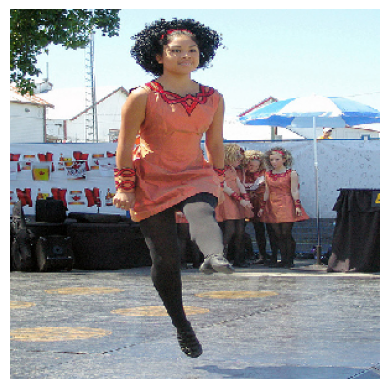

Beam: group of people are standing in front of the mountains
Greedy: man in blue shirt and blue shirt is standing in the air with the other people in the background


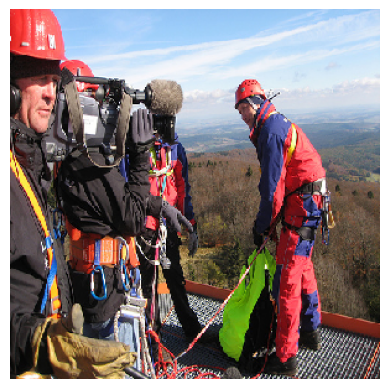

Beam: little girl in pink shirt and white shirt is standing in the grass
Greedy: young girl in pink shirt and white shirt is standing in the grass


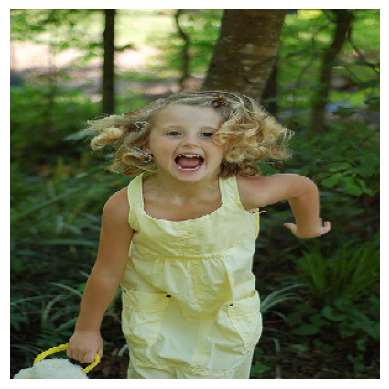

Beam: group of people are standing in the water
Greedy: man in blue shirt is standing on the water with the water


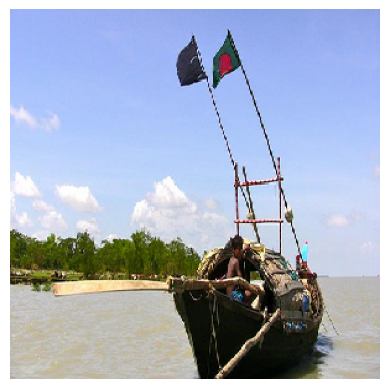

Beam: man in white shirt and blue shirt is sitting on the floor in front of table
Greedy: man in blue shirt and blue shirt is sitting on the floor with the camera


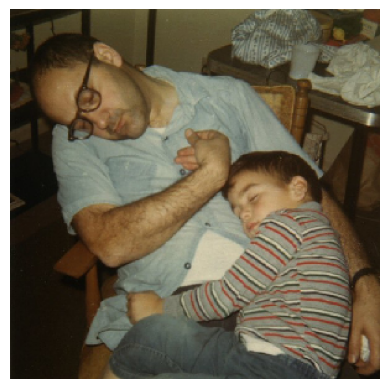

Beam: man in white shirt and white shirt is standing in front of crowd
Greedy: two men in white uniforms are playing in the air in the air


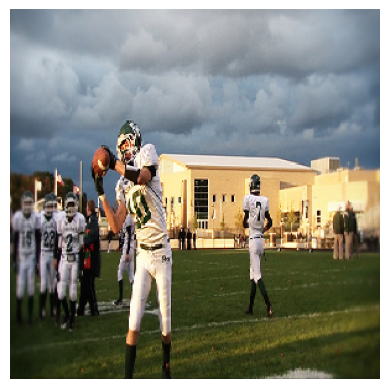

Beam: man in blue shirt is standing in front of the beach
Greedy: man in blue shirt and blue shirt is sitting on the ground with the other man in the background is sitting on the ground


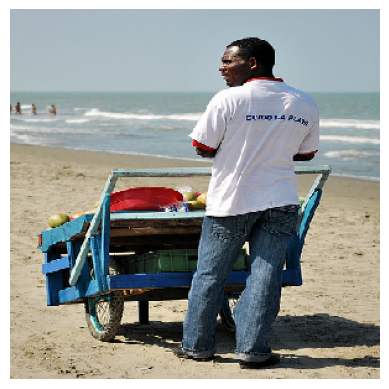

Beam: man in blue shirt and white shirt is standing in front of building
Greedy: man in blue shirt and white shirt is standing on the street


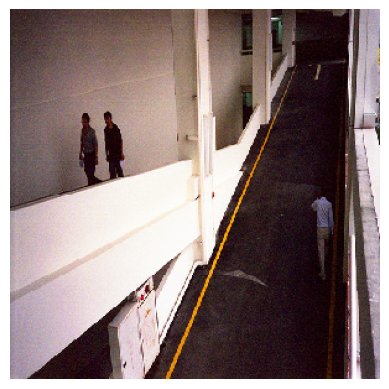

Beam: group of people are standing in the water
Greedy: man in blue shirt and blue shirt is standing on the water


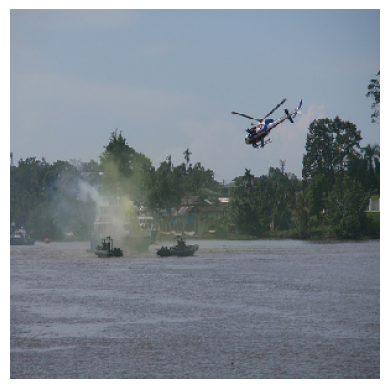

Beam: group of people are standing in front of building
Greedy: man in black shirt and black shirt is standing in front of building with the other people in the background


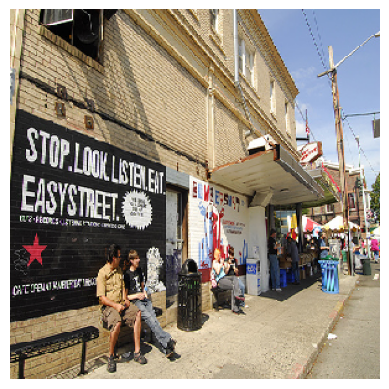

Beam: woman in black shirt and white shirt is standing in the middle of street
Greedy: woman in black shirt and white shirt is standing in front of the camera


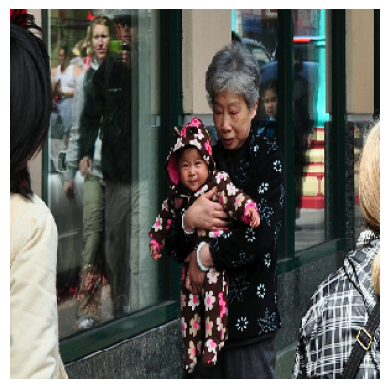

Beam: man in blue shirt is sitting at table in front of table
Greedy: man in blue shirt and blue shirt is sitting on table with the camera


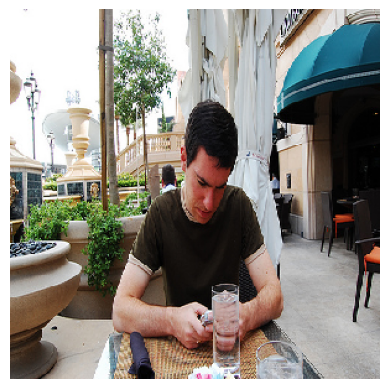

Beam: man in white shirt is standing in front of table
Greedy: man in black shirt and white shirt is sitting on the camera with her hand in the background


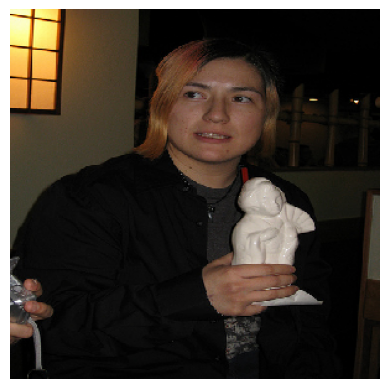

Beam: man in red shirt is riding bike in the street
Greedy: young girl in blue shirt and blue pants is riding bike on the street


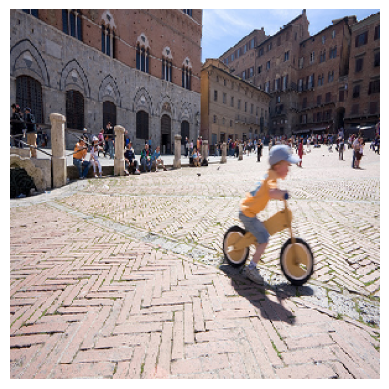

Beam: man in black shirt and black pants is walking down the street
Greedy: man in black shirt and black pants is walking down the street


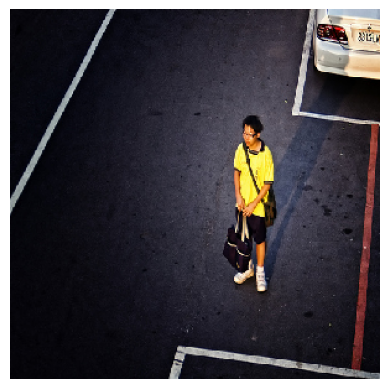

In [48]:
for index, record in samples.iterrows():
    caption= predict_caption_with_beam_search(model, record['image'], tokenizer, PADDING, features, 10)
    print("Beam:", caption)

    caption= predict_caption(model, record['image'], tokenizer, PADDING, features)
    print("Greedy:", caption)
    
    plot_image(read_image(os.path.join(images_path, record['image'])))





<a id="1"></a>
# <div style="text-align:center; border-radius:15px 50px; padding:15px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:#5dade2; overflow:hidden"><b> Predicting Random Sample of Test Images </b></div>

In [96]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# === Parameters ===
image_folder = "/kaggle/input/test-images/TEST_IMAGES" 
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

beam_captions = []
greedy_captions = []
image_paths = []

for img_name in image_files:
    img_path = os.path.join(image_folder, img_name)
    image_paths.append(img_path)
    
    # Generate captions
    beam_caption = predict_caption_with_beam_search(model, img_name, tokenizer, PADDING, features, 10)
    greedy_caption = predict_caption(model, img_name, tokenizer, PADDING, features)

    beam_captions.append(beam_caption)
    greedy_captions.append(greedy_caption)

# === Plotting ===
n_samples = len(image_paths)
num_cols = 3
num_rows = (n_samples + num_cols - 1) // num_cols

plt.figure(figsize=(18, 5 * num_rows))  # Larger image area

for i in range(n_samples):
    plt.subplot(num_rows, num_cols, i + 1)
    
    # Read and show image
    img = read_image(image_paths[i])  # Your own function to read/resize image
    plt.imshow(img)
    plt.axis('off')
    
    # Add both captions in small font
    caption_text = f"Beam: {beam_captions[i]}\nGreedy: {greedy_captions[i]}"
    plt.title(caption_text, fontsize=10)

plt.tight_layout()
plt.show()

# MLFlow
 - Install mlflow using --> !pip install -q dagshub mlflow
 - Host Your MLflow on DagsHub
     - mlflow.set_tracking_uri("https://dagshub.com/<user_name> /<flow_name>.mlflow")
     - mlflow.set_tracking_uri("https://dagshub.com/ahmdeltoky4/image-caption-mlflow.mlflow")
 - Make Your DagsHub Repository Public
     - Go to your DagsHub repo:
        👉 https://dagshub.com/ahmdeltoky4/image-captioning-mlflow
     - Click Settings (top right corner)
     - Find "Repository Visibility"
     - Set it to Public

  - Set an Experiment Name
     - mlflow.set_experiment("Image Captioning Experiment")

  -  Log Parameters, Metrics, Artifacts during model fitting
  -  Share Your MLflow Dashboard -->>  https://dagshub.com/ahmdeltoky4/image-captioning-mlflow.mlflow




In [73]:
!pip install -q dagshub mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 63.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 99.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.2/700.2 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

In [89]:
import mlflow
import os

# Set MLflow tracking URI
mlflow.set_tracking_uri("https://dagshub.com/ahmdeltoky44/image-captioning-mlflow.mlflow")

# Set authentication
os.environ["MLFLOW_TRACKING_USERNAME"] = "ahmdeltoky44"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "f7a8312e9893750889c1cbcd27f97a57177de4dc"

# Set experiment name (must be created in DagsHub)
mlflow.set_experiment("image_captioning_experiment")

2025/05/09 04:49:44 INFO mlflow.tracking.fluent: Experiment with name 'image_captioning_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/10d3ee6bd8c54dc381b05bb8f1fe42eb', creation_time=1746766183967, experiment_id='0', last_update_time=1746766183967, lifecycle_stage='active', name='image_captioning_experiment', tags={}>

In [90]:
import mlflow

configs = [
    {"epochs": 50,"batch_size": 64,
     "padding": 70,"vocab_size": VOCAB_SIZE,
     "lstm_units": 256,"dense_units": 128,
     "dropout_rate": 0.5},
    {"epochs": 50,"batch_size": 64,
     "padding": 70,"vocab_size": VOCAB_SIZE,
     "lstm_units": 128,"dense_units": 64,
     "dropout_rate": 0.3},
    {"epochs": 50,"batch_size": 32,
     "padding": 70,"vocab_size": VOCAB_SIZE,
     "lstm_units": 512,"dense_units": 256,
     "dropout_rate": 0.7}
]

for config in configs:
    with mlflow.start_run():
        
        mlflow.log_param("epochs", config["epochs"])
        mlflow.log_param("batch_size", config["batch_size"])
        mlflow.log_param("padding", config["padding"])
        mlflow.log_param("vocab_size", config["vocab_size"])
        mlflow.log_param("lstm_units", config["lstm_units"])
        mlflow.log_param("dense_units", config["dense_units"])
        mlflow.log_param("dropout_rate", config["dropout_rate"])

        # Build the model with the current configuration
        model = build_model(config["padding"], config["vocab_size"],
                            lstm_units=config["lstm_units"], 
                            dense_units=config["dense_units"], 
                            dropout_rate=config["dropout_rate"])

        # Train model
        history = model.fit(
            train_generator,
            epochs=config["epochs"],
            validation_data=validation_generator,
            callbacks=[checkpoint, earlystopping, learinig_rate_reduction]
        )

        # Log final metrics for this model
        final_val_loss = history.history['val_loss'][-1]
        final_val_accuracy = history.history['val_accuracy'][-1]
        mlflow.log_metric("val_loss", final_val_loss)
        mlflow.log_metric("val_accuracy", final_val_accuracy)

        # Log the model
        mlflow.keras.log_model(model, f"caption_model_lstm{config['lstm_units']}_dense{config['dense_units']}_dropout{config['dropout_rate']}")

        # Log the tokenizer (as a pickle file)
        with open("tokenizer.pkl", "wb") as f:
            pickle.dump(tokenizer, f)
        mlflow.log_artifact("tokenizer.pkl")  

Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.1022 - loss: 6.2802
Epoch 1: val_loss did not improve from 4.04620
297/297 ━━━━━━━━━━━━━━━━━━━━ 97s 315ms/step - accuracy: 0.1024 - loss: 6.2781 - val_accuracy: 0.2109 - val_loss: 4.9357 - learning_rate: 0.0010
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.2095 - loss: 4.9432
Epoch 2: val_loss did not improve from 4.04620
297/297 ━━━━━━━━━━━━━━━━━━━━ 95s 313ms/step - accuracy: 0.2095 - loss: 4.9429 - val_accuracy: 0.2426 - val_loss: 4.5764 - learning_rate: 0.0010
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.2352 - loss: 4.6147
Epoch 3: val_loss did not improve from 4.04620
297/297 ━━━━━━━━━━━━━━━━━━━━ 94s 311ms/step - accuracy: 0.2352 - loss: 4.6146 - val_accuracy: 0.2582 - val_loss: 4.4083 - learning_rate: 0.0010
Epoch 4/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.2505 - loss: 4.4114
Epoch 4: val_loss did not improve from 4.04620
297/297 ━━━━━━━━━━━━━━━━━━━━

2025/05/09 04:58:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/09 04:58:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run shivering-doe-859 at: https://dagshub.com/ahmdeltoky44/image-captioning-mlflow.mlflow/#/experiments/0/runs/cee7af60d2ae4232bf32fa80c4dccba9
🧪 View experiment at: https://dagshub.com/ahmdeltoky44/image-captioning-mlflow.mlflow/#/experiments/0
Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.0887 - loss: 6.4290
Epoch 1: val_loss did not improve from 4.04620
297/297 ━━━━━━━━━━━━━━━━━━━━ 95s 309ms/step - accuracy: 0.0889 - loss: 6.4268 - val_accuracy: 0.1928 - val_loss: 5.0978 - learning_rate: 0.0010
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.1973 - loss: 5.0315
Epoch 2: val_loss did not improve from 4.04620
297/297 ━━━━━━━━━━━━━━━━━━━━ 93s 309ms/step - accuracy: 0.1973 - loss: 5.0312 - val_accuracy: 0.2280 - val_loss: 4.6782 - learning_rate: 0.0010
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.2253 - loss: 4.6719
Epoch 3: val_loss did not improve from 4.04620
297/297 ━━━━━━━━━━━━━━━━━━━━ 93s 308ms/step - accuracy

2025/05/09 05:06:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/09 05:06:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run burly-stag-394 at: https://dagshub.com/ahmdeltoky44/image-captioning-mlflow.mlflow/#/experiments/0/runs/d1edb53f753542e3bc0c4e1dafadf3fa
🧪 View experiment at: https://dagshub.com/ahmdeltoky44/image-captioning-mlflow.mlflow/#/experiments/0
Epoch 1/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.1078 - loss: 6.2140
Epoch 1: val_loss did not improve from 4.04620
297/297 ━━━━━━━━━━━━━━━━━━━━ 106s 346ms/step - accuracy: 0.1079 - loss: 6.2121 - val_accuracy: 0.2144 - val_loss: 4.9469 - learning_rate: 0.0010
Epoch 2/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.2096 - loss: 5.0192
Epoch 2: val_loss did not improve from 4.04620
297/297 ━━━━━━━━━━━━━━━━━━━━ 105s 347ms/step - accuracy: 0.2096 - loss: 5.0190 - val_accuracy: 0.2448 - val_loss: 4.6098 - learning_rate: 0.0010
Epoch 3/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.2337 - loss: 4.7141
Epoch 3: val_loss did not improve from 4.04620
297/297 ━━━━━━━━━━━━━━━━━━━━ 105s 349ms/step - accuracy

2025/05/09 05:15:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/09 05:15:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run powerful-snipe-218 at: https://dagshub.com/ahmdeltoky44/image-captioning-mlflow.mlflow/#/experiments/0/runs/71370e54127d4822b8f409cb47c8a909
🧪 View experiment at: https://dagshub.com/ahmdeltoky44/image-captioning-mlflow.mlflow/#/experiments/0


[`**Check Flow Here**`](https://dagshub.com/ahmdeltoky44/image-captioning-mlflow.mlflow)

[`**Or Check Here**`](https://dagshub.com/ahmdeltoky44/image-captioning-mlflow.mlflow)
